# Машинное обучение, ФЭН ВШЭ

__Дата выдачи: 26.11.2017__
__Дедлайн: 15.12.2017 23:59__

# Практическое задание 4


### О задании

Практическое задание 4 посвящено ансамблям, bias-variance decomposition, деревьям и нейронным сетям. Обучение нейронных сетей займет какое-то время, поэтому не оставляйте эту часть на последний день!

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW4_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW4_IvanovII.ipynb*). Далее отправьте этот файл на *ml.econom.hse@gmail.com* с темой *Практика {номер задания} - номер группы по данному курсу - Фамилия Имя* 

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [25]:
import numpy as np

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [12]:
x = np.random.normal(loc=5, scale=3, size=1000)
(x**2).mean()

34.968572185694242

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [15]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=1000)
(X**2).sum(axis=1).mean()

20.159433220438842

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
#####  Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [26]:
from matplotlib import pyplot as plt
%matplotlib inline

In [27]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков

__1 (0.6 балла)__
1. Сгенерируйте выборку x из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных y как сумму f(x) и случайного шума, сгенерированного из равномерного распределения на отрезке [-1, 1] (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: f(x) и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

In [28]:
linspace=linspace[:,np.newaxis]

In [29]:
#1
x=np.random.exponential(size=100)
#2
y=f(x)+np.random.uniform(-1,1,size=100)

In [30]:
X=x[:,np.newaxis]
Y=y[:,np.newaxis]

In [31]:
from sklearn.tree import DecisionTreeRegressor

In [32]:
DT=DecisionTreeRegressor(random_state=42)
DT.fit(X,Y)
Y_pred=DT.predict(linspace)

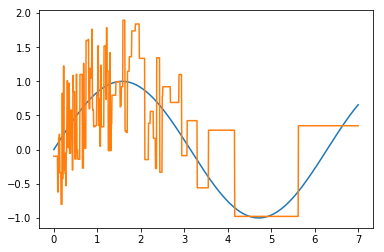

In [88]:
plt.plot(linspace,f(linspace))
plt.plot(linspace,Y_pred)

__2 (0.6 балла):__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

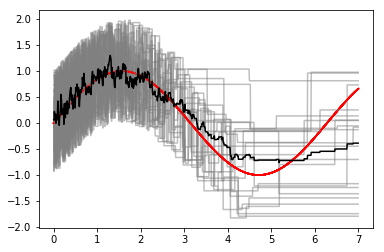

In [33]:
Y_mean=[]
for num in range(samples_num):
    x=np.random.exponential(size=100)
    y=f(x)+np.random.uniform(-1,1,size=100)
    X=x[:,np.newaxis]
    Y=y[:,np.newaxis]
    DT=DecisionTreeRegressor(random_state=42)
    DT.fit(X,Y)
    Y_pred=DT.predict(linspace)
    Y_mean.append(Y_pred)
    plt.plot(linspace,f(linspace),color='red')
    plt.plot(linspace,Y_pred, color="gray", alpha=0.5)
plt.plot(linspace,np.mean(Y_mean, axis=0),color='black')
    

__3 (0.2 балла):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика.

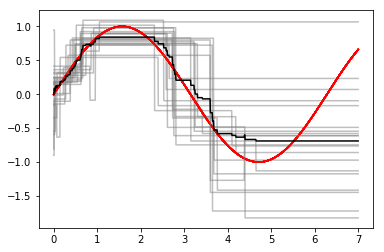

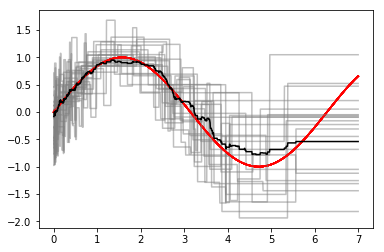

In [35]:
Y_mean=[]
Depth_list=[2,4]
for d in Depth_list:
    plt.show()
    for num in range(samples_num):
        x=np.random.exponential(size=100)
        y=f(x)+np.random.uniform(-1,1,size=100)
        X=x[:,np.newaxis]
        Y=y[:,np.newaxis]
        DT=DecisionTreeRegressor(max_depth=d,random_state=42)
        DT.fit(X,Y)
        Y_pred=DT.predict(linspace)
        Y_mean.append(Y_pred)
        plt.plot(linspace,f(linspace),color='red')
        plt.plot(linspace,Y_pred, color="gray", alpha=0.5)
    plt.plot(linspace,np.mean(Y_mean, axis=0),color='black')

__4 (0.6 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

(・・ ) ?



__5 (1 балл)__
Проделайте тот же эксперимент с линейной регрессией и SVM с rbf ядром и параматрами $\gamma = 1$, $\gamma = 100$. Какие выводы можно сделать?

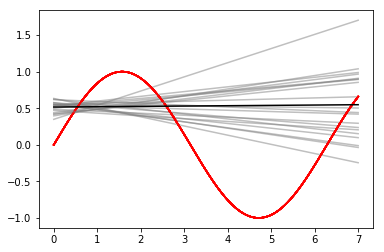

In [36]:
from sklearn.linear_model import LinearRegression
Y_mean=[]
for num in range(samples_num):
    x=np.random.exponential(size=100)
    y=f(x)+np.random.uniform(-1,1,size=100)
    X=x[:,np.newaxis]
    Y=y[:,np.newaxis]
    LR=LinearRegression()
    LR.fit(X,Y)
    Y_pred=LR.predict(linspace)
    Y_mean.append(Y_pred)
    plt.plot(linspace,f(linspace),color='red')
    plt.plot(linspace,Y_pred, color="gray", alpha=0.5)
plt.plot(linspace,np.mean(Y_mean, axis=0),color='black')

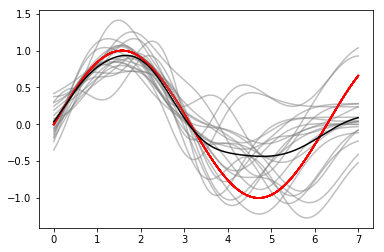

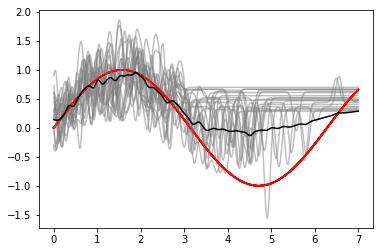

In [37]:
from sklearn.svm import SVR
Y_mean=[]
gamma_list=[1,100]
for g in gamma_list:
    plt.show()
    for num in range(samples_num):
        x=np.random.exponential(size=100)
        y=f(x)+np.random.uniform(-1,1,size=100).ravel()
        X=x[:,np.newaxis]
        Y=y[:,np.newaxis].ravel()
        s=SVR(kernel='rbf', gamma=g)
        s.fit(X,Y)
        Y_pred=s.predict(linspace).ravel()
        Y_mean.append(Y_pred)
        plt.plot(linspace,f(linspace),color='red')
        plt.plot(linspace,Y_pred, color="gray", alpha=0.5)
    plt.plot(linspace,np.mean(Y_mean, axis=0),color='black')

Как видно из оценённых моделей, лучше всех показала себя модель с Decision Tree, регрессия, будучи лнейной моделью, не смогла предсказать нелинейные частки, а SVR с параметров гамма равным 1 проигрывает по качеству модели Decision Tree

### II. Решающие деревья

__5 (1 балл)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-rac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc - это класс 0, good, vgood - класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend - класс 0, very_recom, priority, spec_prior - класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTreeClassifier, считающий все признаки вещественными
* DecisionTreeClassfier, считающий все признаки категориальными
* DecisionTreeClassifier, c корректным разбиением на категориальные и вещественные признаки.

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.

In [38]:
import pandas as pd
url1='https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data'
url2='https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data'
url3='https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data'
url4='https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data'
msh= pd.read_csv(url1,encoding='latin1',header=None)
ttt=pd.read_csv(url2,encoding='latin1',header=None)
cars=pd.read_csv(url3,encoding='latin1',header=None)
nursery=pd.read_csv(url4,encoding='latin1',header=None)

In [87]:
nursery[8].head()

0    0
1    1
2    0
3    0
4    1
Name: 8, dtype: int64

In [39]:
from sklearn.preprocessing import LabelEncoder
ttt[9]=ttt[9].apply(lambda x: 0 if x=='negative' else 1)
cars[6] = cars[6].apply(lambda x: 0 if x == 'unacc' or x=='acc' else 1)
nursery[8]=nursery[8].apply(lambda x: 0 if x=='not_recom' or x=='recommend' else 1)

In [40]:
def dummies(data):
    category = data.select_dtypes(exclude = [np.number])
    y=data._get_numeric_data()
    category=pd.get_dummies(category)
    return category,y

In [41]:
def labels(X):
    le = LabelEncoder()
    obj_features = X.columns[X.dtypes == 'object']
    for feature in obj_features:
        X[feature] = le.fit_transform(X[feature])

In [42]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [43]:
labels(cars)
labels(ttt)
labels(msh)
labels(nursery)

In [45]:
def DT_for_categorial(dataframe):
    numpy_values=dataframe.values
    y=np.array(numpy_values[::1, -1])
    X=np.array(numpy_values[::1,0:numpy_values.shape[1]-1])
    DT=DecisionTreeClassifier(random_state=2)
    print(np.mean(cross_val_score(DT, X, y, scoring=make_scorer(accuracy_score), cv=10)))

In [46]:
DT_for_categorial(cars)
DT_for_categorial(ttt)
DT_for_categorial(msh)
DT_for_categorial(nursery)

0.94097166533
0.725289157171
0.482409620763
0.999691477008


In [279]:
def DT_for_dummies(dataframe,y):
    numpy_values=dataframe.values
    numpy_values_y=y.values
    X=np.array(numpy_values[::1,],dtype=np.float32)
    y=np.array(numpy_values_y[::1,],dtype=np.float32)
    DT=DecisionTreeClassifier(random_state=2)
    print(cross_val_score(DT, X.T, y.T, scoring=make_scorer(accuracy_score), cv=10))

In [275]:
DF,y=dummies(cars)
numpy_values=DF.values
numpy_values_y=y.values
X=np.array(numpy_values[::1,],dtype=np.float32)
y=np.array(numpy_values_y[::1,],dtype=np.float32)

In [47]:
# можно улучшить работу если сделать парвильное разбиение на класы

__6 (0.5 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

(・・ ) ?


### III. Композиции деревьев
#### Сравнение композиционных методов над решающими деревьями
__7 (1 балл)__

Выполните следующие шаги:
1. Загрузите датасет [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в датафрейм. Последний столбец - целевая переменная (содержит классы).
1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * BaggingClassifier со 100 деревьями; каждое дерево обучается только по половине случайно выбранных признаков (см. параметры метода)
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом. Этот пример демонстрирует, что RandomForest - это более сложный алгоритм, чем бэггинг и бэггинг со случайными подпространствами. 

In [279]:
df=pd.read_csv('winequality-red.csv',sep=';')
y=df['quality']
X=df.drop(['quality'],axis=1)

In [280]:
y.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [265]:
from sklearn.model_selection import StratifiedKFold
scv=StratifiedKFold(n_splits=3,shuffle=True)

Классы несбалансированы поэтому будем использовать StratifiedKFold CV

In [271]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
BC_1=BaggingClassifier(n_estimators=100)
BC_2=BaggingClassifier(n_estimators=100,max_features=0.5)
RF=RandomForestClassifier(n_estimators=100)

In [274]:
print('accuracy for DT',cross_val_score(DT, X, y, scoring=make_scorer(accuracy_score), cv=scv))
print('accuracy for BC_1',cross_val_score(BC_1, X, y, scoring=make_scorer(accuracy_score), cv=scv))
print('accuracy for BC_2',cross_val_score(BC_2, X, y, scoring=make_scorer(accuracy_score), cv=scv))
print('accuracy for RF',cross_val_score(RF, X, y, scoring=make_scorer(accuracy_score), cv=scv))

accuracy for DT [ 0.57570093  0.62288931  0.63276836]
accuracy for BC_1 [ 0.68785047  0.65290807  0.65536723]
accuracy for BC_2 [ 0.67102804  0.64727955  0.65160075]
accuracy for RF [ 0.67102804  0.69230769  0.70433145]


#### Число деревьев в случайном лесе
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__8 (1 балл)__

Продолжим работать с набором данных [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv). Разделите выборку на обучение и контроль с пропорции 7:3, предварительно перемешав объекты. Переберите значения от 100 до 5000 деревьев с шагом 100, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $100 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [354]:
from sklearn.utils import shuffle
df_new=shuffle(df)
y=df['quality']
X=df.drop(['quality'],axis=1)

In [355]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [356]:
tree_list=np.arange(start=100,stop=5000,step=100)

In [357]:
RF=RandomForestClassifier(warm_start=True)
RF.fit(X_train,y_train)
y_pred=RF.predict(X_test)

In [358]:
acc_list=[]
for tree in tree_list:
    ch_param=RF.set_params(n_estimators=tree)
    y_fitted=ch_param.fit(X_train,y_train)
    pred_value=ch_param.predict(X_test)
    acc_list.append(accuracy_score(y_test,pred_value))
    

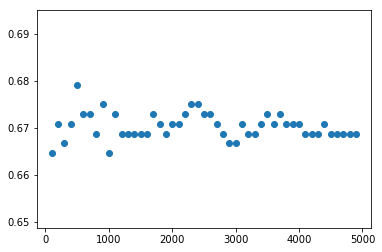

In [361]:
plt.scatter(tree_list,acc_list)

качество выходит на ассимптоту после некоторого порога деревьев

### IV. Нейронные сети

*На обучение нейросетей может уйти больше часа, не откладывайте этот пункт на последний день*.

__9 (1 балл)__

В этом задании вам предстоит обучить нейронную сеть на датасете [MNIST](https://en.wikipedia.org/wiki/MNIST_database) с помощью пакета [keras](https://keras.io).

In [1]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


Обучите нейронную сеть с двумя скрытыми слоями в каждой из которых поместите по 100 нейронов. Какого качества удается добиться на тесте?

In [2]:
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,Activation
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.utils import np_utils
import keras

In [4]:
print(x_train.shape)


(60000, 28, 28)


In [5]:
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [6]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [7]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [8]:
y_train[:6]

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [9]:
input_shape

(28, 28, 1)

In [10]:
model = Sequential()
model.add(Dense(10, activation='relu', input_shape=input_shape))
model.add(Dense(100, activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [11]:
from keras.callbacks import EarlyStopping
earlystopping= EarlyStopping(monitor = 'val_loss',
                            min_delta=0,
                            patience = 1,
                            verbose=0, mode='auto')

In [12]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])

In [15]:
model.fit(x_train, y_train,batch_size=125,epochs=1,verbose=1,validation_data=(x_test, y_test),callbacks = [earlystopping])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 529s - loss: 0.2438 - acc: 0.9293 - val_loss: 0.2205 - val_acc: 0.9338

#### Как видно в модели с двумя скрытыми слоями по 100 нейронов в каждом, удачётся достичь качества в 0,93 процента, однако его можно улучшить

In [19]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(10, activation='softmax'))

In [20]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])

In [22]:
model.fit(x_train, y_train,batch_size=128,epochs=8,verbose=1,validation_data=(x_test, y_test),callbacks = [earlystopping])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/8
60000/60000 [==============================] - 151s - loss: 0.2874 - acc: 0.9127 - val_loss: 0.0751 - val_acc: 0.9775